# Notebook for binary data preparation

In [241]:
import pandas as pd

In [115]:
import os
def list_files_recursive(files, path='.'):
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            list_files_recursive(files, full_path)
        else:
            files.append(full_path)

In [160]:
file_names = []
list_files_recursive(file_names, '../data/raw')

whole_df = pd.DataFrame()
for file_name in file_names:
    if file_name.endswith('.svc'):
        user = file_name.split('/')[-3]
        session = file_name.split('/')[-2]
        df = pd.read_csv(file_name,  delimiter=r"\s+", skiprows=[0], header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'azimuth', 'altitude', 'pressure']
        df['user'] = user
        df['session'] = session
        df['collection'] = file_name.split('../data/raw/')[1].split('/')[0]
        
        whole_df = pd.concat([whole_df, df], axis=0)


In [161]:
labels_df['id'] = labels_df['Directory'] + labels_df['File Number user'].apply(lambda x: 'user' + str(x).rjust(5, '0'))

In [162]:
whole_df['id'] = whole_df['collection'] + whole_df['user']

In [163]:
whole_df.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user,session,collection,id
0,51121,34662,1992990,1,1800,530,1,user00015,session00001,Collection2,Collection2user00015
1,51143,34656,1992997,1,1800,530,24,user00015,session00001,Collection2,Collection2user00015
2,51151,34653,1993005,1,1800,530,44,user00015,session00001,Collection2,Collection2user00015
3,51158,34651,1993012,1,1800,530,57,user00015,session00001,Collection2,Collection2user00015
4,51163,34649,1993020,1,1800,530,67,user00015,session00001,Collection2,Collection2user00015


In [164]:
labels_df.head()

,Suject,depression,anxiety,stress,Database Collectors,File Number user,Directory,user,id
0,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001,Collection1user00001
1,2,1,10,8,Passaniti; De Feo,2,Collection1,user00002,Collection1user00002
2,3,5,3,3,Passaniti; De Feo,3,Collection1,user00003,Collection1user00003
3,4,13,15,19,Passaniti; De Feo,4,Collection1,user00004,Collection1user00004
4,5,5,3,5,Passaniti; De Feo,5,Collection1,user00005,Collection1user00005


In [174]:
labeled_data = pd.merge(whole_df, labels_df, how='inner', on='id')

In [175]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user_x,session,collection,id,Suject,depression,anxiety,stress,Database Collectors,File Number user,Directory,user_y
0,51121,34662,1992990,1,1800,530,1,user00015,session00001,Collection2,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2,user00015
1,51143,34656,1992997,1,1800,530,24,user00015,session00001,Collection2,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2,user00015
2,51151,34653,1993005,1,1800,530,44,user00015,session00001,Collection2,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2,user00015
3,51158,34651,1993012,1,1800,530,57,user00015,session00001,Collection2,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2,user00015
4,51163,34649,1993020,1,1800,530,67,user00015,session00001,Collection2,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2,user00015


In [176]:
labeled_data.drop(['Directory', 'File Number user', 'user_x', 'session', 'collection', 'id', 'Database Collectors', 'Directory', 'user_y'], axis=1, inplace=True)

In [177]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,Suject,depression,anxiety,stress
0,51121,34662,1992990,1,1800,530,1,60,4,3,6
1,51143,34656,1992997,1,1800,530,24,60,4,3,6
2,51151,34653,1993005,1,1800,530,44,60,4,3,6
3,51158,34651,1993012,1,1800,530,57,60,4,3,6
4,51163,34649,1993020,1,1800,530,67,60,4,3,6


In [183]:
labeled_data[labeled_data['Suject']==1]

,x,y,timestamp,pen_status,azimuth,altitude,pressure,Suject,depression,anxiety,stress
2080643,34566,36143,724770,1,1820,590,212,1,2,8,13
2080644,34546,36112,724777,1,1820,600,314,1,2,8,13
2080645,34492,36097,724785,1,1820,600,388,1,2,8,13
2080646,34412,36081,724792,1,1820,600,473,1,2,8,13
2080647,34304,36065,724800,1,1820,600,523,1,2,8,13
...,...,...,...,...,...,...,...,...,...,...,...
2096600,6709,6953,875051,1,2210,690,852,1,2,8,13
2096601,6712,6914,875058,1,2210,690,838,1,2,8,13
2096602,6717,6872,875066,1,2190,700,793,1,2,8,13
2096603,6719,6837,875073,1,2190,700,703,1,2,8,13


In [236]:
import matplotlib.pyplot as plt

sample_subject_data = labeled_data[(labeled_data['Suject']==69) & (labeled_data['pen_status']==1)]


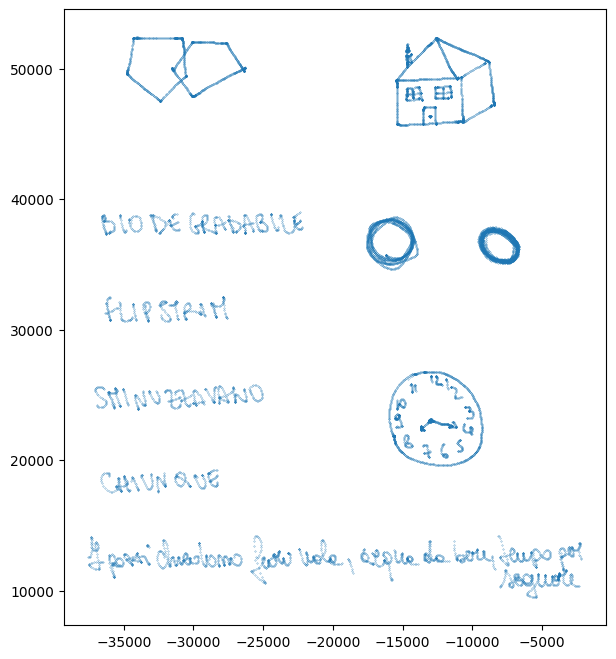

In [237]:
plt.figure(figsize=(7,8))
plt.scatter(-sample_subject_data['y'], sample_subject_data['x'], s=0.05 )

In [240]:
labeled_data.to_parquet('../data/binary_raw/labeled_data.parquet')